# Augmented Markov models, a walk-through tutorial
Author: Simon Olsson (simon.olsson@fu-berlin.de) [@smnlssn](http://twitter.com/smnlssn)

December 2017

Augmented Markov models (AMM) are a flavor or of Markov state models (MSM) which take into account experimental data during model estimation. Using AMMs we can partially compensate for systematic errors in empirical MD forcefields or equivalently in coarse-grained models, and thereby hopefully get more accurate physical descriptions of thermodynamics and molecular kinetics of molecular systems.

In our [recent paper](http://www.pnas.org/content/114/31/8265.abstract) we present the first statistical estimator of its kind, which allows for the integration of stationary expectation values as restraints. By stationary expectation value we mean
$$ \mathbf{o} = \int \mathrm{d}x\; o(x)p(x)\, , \; \, \, \, \, \,p(x)=\mathcal{Z}^{-1}\exp(-\beta E(x)) $$
where $\mathbf{o}$ is an experimentally measured value, $o(x)$ is a _forward model_ which back-computes a micro-scopic, instantaneous value of the experimental observable. $p(x)$ is the Boltzmann distribution corresponding to the potential energy function $E(x)$ and $x$ is a molecular configuration. Consequently, these observables are time and ensemble averages over a large number of molecules, such as those obtained in bulk experiments including NMR spectroscopy. 

Although we currently only allow for integration of stationary observables, we anticipate to extend support to dynamic observables in the near future. In the mean-time dynamic observables from experiments such as [FRET](http://www.pnas.org/content/108/12/4822.abstract) and [NMR Relaxation dispersion](http://pubs.acs.org/doi/abs/10.1021/jacs.6b09460) may be used for validation. We show an example of this in the end of this notebook

### Prerequisites 
In this tutorial I assume some familiarity with MSM theory and possibly also some practical experience, such as going through [this](http://www.emma-project.org/latest/generated/MSM_BPTI.html) PyEMMA tutorial. I recommend working your way through this tutorial if you are not already familiar with MSMs or if you are not familiar with PyEMMA.

### Technical requirements
* Python 3
* PyEMMA 2.5 (release date pending), for now one can use an installation from the devel branch on github
* Numpy
* mdtraj 2.0 or higher
* matplotlib

### Content of this notebook
* A quick primer to AMMs using a simple 1D double-well potential
* Using experimental J-couplings and MD simulations to build an AMM of the protein GB3
* Sanity checks and hyper-parameter optimization

In [1]:
%matplotlib inline
import pyemma as pe
from pyemma.datasets import double_well_discrete
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
print("PyEMMA version", pe.version)
print("MDTraj version", md.version.version)

PyEMMA version 2.4+526.g27a2fa3e
MDTraj version 2.0.0.dev0


### Preparation of double-well data
We extract pre-generated data from a double-well potential and discretize it into 20 evenly sized bins. In a practical setting of a molecular system one would perform dimensionalty reduction of some molecular features, cluster the simulation data in this space, and then use use the discretized trajectories down-stream.

In [3]:
double_well_data = double_well_discrete.DoubleWell_Discrete_Data()
reaction_coordinate = np.linspace(10,90,25, dtype='int')[:-1]
discrete_trajectory_20bins = double_well_data.dtraj_T100K_dt10_n(np.linspace(10,90,25, dtype='int').tolist())

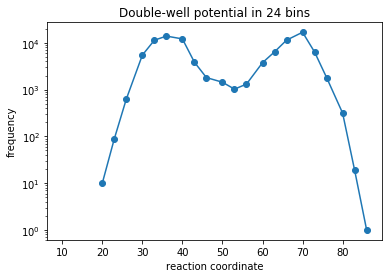

In [4]:
plt.semilogy(reaction_coordinate, np.bincount(discrete_trajectory_20bins),'o-')
plt.xlabel('reaction coordinate')
plt.ylabel('frequency')
plt.title('Double-well potential in %i bins'%(len(np.bincount(discrete_trajectory_20bins))))

### Selecting a suitable Markov state model
Plotting implied time-scales and selecting the model with lag-time of 35 time-steps

100%|██████████| 9/9 [00:01<00:00,  4.74it/s]                                 


(0, 350)

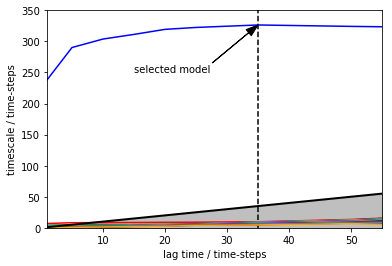

In [5]:
lags = [1,5,10,15,20,25,35,50,55]
implied_ts = pe.msm.its(dtrajs=discrete_trajectory_20bins,lags=lags)
pe.plots.plot_implied_timescales(implied_ts,units='time-steps', ylog=False)
plt.vlines(35,ymin=0,ymax=350,linestyles='dashed')
plt.annotate("selected model", xy=(lags[-3], implied_ts.timescales[-3][0]), xytext=(15,250),
                 arrowprops=dict(facecolor='black', shrink=0.001, width=0.1,headwidth=8))
plt.ylim([0,350])

In [6]:
M = pe.msm.estimate_markov_model(dtrajs=discrete_trajectory_20bins, lag = lags[-3])

### Performing a Chapman-Kolmogorov test
To test self-consistency with training-data.

In [7]:
cktest = M.cktest(nsets=2)

100%|██████████| 9/9 [00:01<00:00,  5.07it/s]                                 


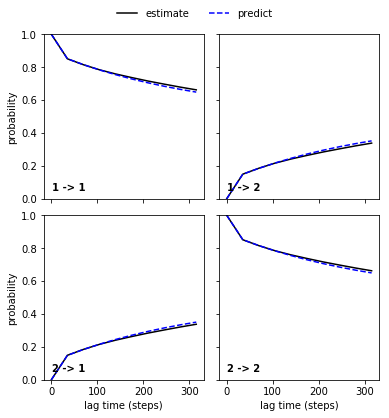

In [8]:
cktplt = pe.plots.plot_cktest(cktest)

Looks good!


### Experimental observables

Now, let's check agreement with some synthetic experimental value which depends on our reaction coordinate from above.

First we compute the observable for each discrete states in our simulation data. Here, we map each bin on our axis to a point in the range $\theta \in [0,\pi]$ and compute a faux experimental J-coupling observable using the Karplus equation,
$$ ^3J(\theta) = 3.2\cos^2(\theta) - 1.3\cos(\theta) + 4.2 $$

In [9]:
_theta = np.linspace(0, np.pi, len(reaction_coordinate))
f_obs = 3.2*np.cos(_theta)**2 - 1.3*np.cos(_theta) + 4.2

In the case of a molecular system, one would compute some observable of interest for all the frames in our molecular simulation, and then average the predicted observable in each cluster/Markov state. But more about that below ...

We can use the ``expectation`` method of our PyEMMA MSM instance to compute weighted ensemble averages:

In [10]:
print("Our simulated J-coupling is: %1.1fHz"%M.expectation(f_obs[M.active_set]).round(2))

Our simulated J-coupling is: 5.5Hz


Note how we have selected a subset (M.active_set) of the original clusters/discrete states. We do this, as there is no gaurantee that the MSM describes all of the states well. In general, PyEMMA finds the 'largest connected set', which is the larget set of clusters which we have both entered and exited.

Say we have measured an experimental value, which is 4.1Hz with an uncertainty of 0.8Hz. In such a case, we have a clear discrepancy between the predicted and experimental values. In this such cases we can use AMMs to hopefully improve the model. With PyEMMA it is easy to try this out once you have established a regular Markov state model.

First we compute the experimental observable for all our simulation frames in ftraj

In [11]:
ftrajs = f_obs[discrete_trajectory_20bins].reshape(-1,1)

Then we have a convienence function ``estimate_augmented_markov_model`` to estimate AMMs by simply providing the ftraj, experimental averages and uncertainties:

In [12]:
AMM = pe.msm.estimate_augmented_markov_model(dtrajs = [discrete_trajectory_20bins], #Discrete trajectories as for the MSM
                                             ftrajs = [ftrajs], #Trajectories projected onto experimental observable
                                             lag = lags[-3],  # same lag-time as the one validated for the MSM
                                             m = np.array([4.1]),  # experimental average
                                             sigmas = np.array([0.8]), # experimental uncertainty
                                             maxiter=50000) # Maximum number of iterations

20-12-17 20:30:24 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[2] INFO     Total experimental constraints outside support 0 of 1
20-12-17 20:30:25 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[2] INFO     Converged Lagrange multipliers after 240 steps...
20-12-17 20:30:25 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[2] INFO     Converged pihat after 240 steps...


## That is it! 
We get some useful information as output here: All our experimental data are within the support. Lagrange multipliers and biased ensemble estimate both converged after 2 iterations.

Let's compare the stationary properties of our AMM with the corresponding MSM.

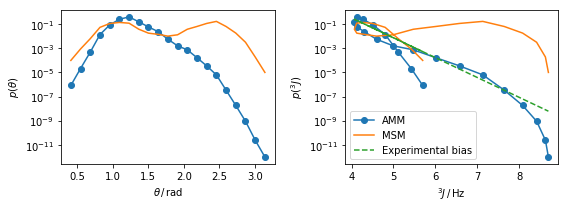

In [13]:
bias_potential=np.exp(AMM.lagrange[0]*f_obs[M.active_set])
bias_potential=bias_potential/bias_potential.sum()

fig,ax=plt.subplots(ncols=2,figsize=(8,3))
ax[0].semilogy(_theta[AMM.active_set], AMM.stationary_distribution,'-o',label='AMM')
ax[0].semilogy(_theta[M.active_set], M.stationary_distribution, label='MSM')
ax[0].set_xlabel(r'$\theta\, /\, \mathrm{rad}$')
ax[0].set_ylabel(r'$p(\theta)$')
ax[1].semilogy(f_obs[AMM.active_set], AMM.stationary_distribution,'-o',label='AMM')
ax[1].semilogy(f_obs[M.active_set], M.stationary_distribution, label='MSM')
ax[1].semilogy(f_obs[M.active_set], bias_potential,'--', label='Experimental bias')
ax[1].set_xlabel(r'$^3J\, /\, \mathrm{Hz}$')
ax[1].set_ylabel(r'$p(^3J)$')
ax[1].legend()
plt.tight_layout()


The plots above show the AMM stationary distribution versus the $\theta$ and $^3J$ variables defined above. The dashed green line in the plot on the right shows the bias introduced by the experimental data. The slope of this curve is given by the Lagrange multiplier estimated.

We can also check whether we are closer to the experimental - _drumroll_ ...

In [14]:
print("Our AMM J-coupling is: %1.1fHz"%AMM.expectation(f_obs[AMM.active_set]).round(2))

Our AMM J-coupling is: 4.2Hz


Which closer to our 'experimental' average of 4.1Hz. 

Try to play around with the experimental average and uncertainty to get some as to how the AMM estimator changes the stationary properties as a function these parameters.

### Bonus information for advanced users

Instead of using the convienence function above we can also build AMM instances directly. In this manner we have have more flexibility in terms of input and manipulation of the instance before actually estimating the AMM. Fx we can use a E-matrix as a way to input our predicted observables for each Markov state. This matrix must have the dimensions number_of_discrete_states times number_of_experimental_observables

In [15]:
AMM_Advanced_inst = pe.msm.AugmentedMarkovModel(lag=lags[-3], 
                                           E = AMM.E, #Average experimental observable in each discrete state
                                           m = np.array([4.1]),
                                           w = np.array([1./2./0.8**2]),
                                           maxiter = 50000
                                          )
AMM_Advanced_est = AMM_Advanced_inst.estimate(discrete_trajectory_20bins)

20-12-17 20:30:26 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[3] INFO     Total experimental constraints outside support 0 of 1
20-12-17 20:30:26 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[3] INFO     Converged Lagrange multipliers after 240 steps...
20-12-17 20:30:26 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[3] INFO     Converged pihat after 240 steps...


In [16]:
print("We check whether the results are consistent:",np.allclose(AMM_Advanced_est.stationary_distribution, AMM.stationary_distribution))

We check whether the results are consistent: True


# AMM of GB3 
To illustrate the use of AMMs for a small molecular system, we turn to GB3. We use back-bone torsions from a number of residues previously shown to be flexible. Below we execute the following protocol:

* We featurize 35 short MD trajectories, 
* Perform TICA dimensionality reduction to 2 dimensions
* Cluster to 256 cluster centers
* Select a MSM with lag-time 40 nanoseconds (based upon an implied time-scale plot and a CK test above.)

Please note that this data-set is relatively small (~14 microseconds) and uncertainties of the quantities therefore will be large. For illustrative purposes we will here not dewell on this point further here.


In [17]:
feat = pe.coordinates.featurizer("gb3_data/gb3_backbone_top.pdb")

In [18]:
for ri in [8,9,10,11,12,13,14,36,37,38,39,40,41]:
    feat.add_backbone_torsions(selstr='residue %i'%ri, cossin=True)


In [19]:
source = pe.coordinates.source(['gb3_data/gb3_backbone_{:03d}.xtc'.format(i) for i in range(35)], features=feat)

100%|██████████| 35/35 [00:00<00:00, 191.25it/s]                     


In [20]:
lag=55
tica_obj = pe.coordinates.tica(source, lag=lag, dim=2)

Y = tica_obj.get_output() # get tica coordinates

100%|██████████| 35/35 [00:01<00:00, 21.62it/s]                        


20-12-17 20:31:28 pyemma.coordinates.clustering.kmeans.KmeansClustering[6] INFO     Cluster centers converged after 5 steps.


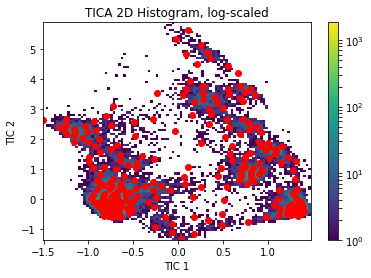

In [21]:
pe.config.show_progress_bars = False
Y_all = np.vstack(Y)
n_clusters = 256 # number of k-means clusters

clustering = pe.coordinates.cluster_kmeans(Y, k = n_clusters, max_iter = 100, stride = 10)

dtrajs = clustering.assign(Y)

cx = clustering.clustercenters[:,0]
cy = clustering.clustercenters[:,1]

plt.hist2d(Y_all[:, 0], Y_all[:, 1], bins=100, norm = mpl.colors.LogNorm())
plt.colorbar()
plt.scatter(cx, cy,  marker='o',  color='red')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')
plt.title('TICA 2D Histogram, log-scaled')


### Model selection and self-consitency checks

In [22]:
time_step_ps = 200
lags = range(5,400,40)
its = pe.msm.its(dtrajs, lags=lags, nits=1, reversible=True)


(0, 1500)

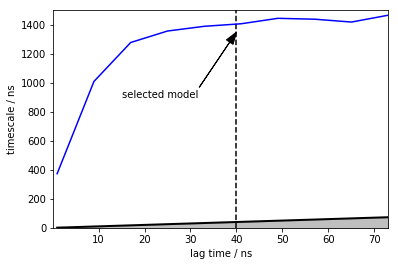

In [23]:
pe.plots.plot_implied_timescales(its, ylog = False, dt=time_step_ps*1e-3, units='ns')
plt.vlines(40,ymin=0,ymax=1500,linestyles='dashed')
plt.annotate("selected model", xy=(40, 1350), xytext=(15,900),
                 arrowprops=dict(facecolor='black', shrink=0.001, width=0.1,headwidth=8))
plt.ylim([0,1500])

In [24]:
M_gb3 = pe.msm.estimate_markov_model(dtrajs, lag=200)

In [25]:
ckt_gb3 = M_gb3.cktest(2, mlags=5)

(<matplotlib.figure.Figure at 0x11736e2e8>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1178d2c88>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x119778c50>]], dtype=object))

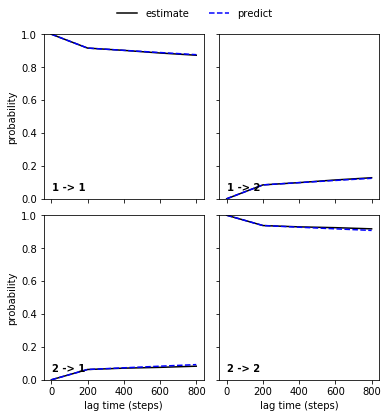

In [26]:
pe.plots.plot_cktest(ckt_gb3)

### Computation of scalar couplings from simulation data
We use a dataset of HN-HA scalar couplings and Karplus parameters [from this paper](https://doi.org/10.1016/j.dib.2015.08.020) to test the quality of our MSM. This observable is sensitive to the ensemble of sampled $\phi$ angles. 


In [27]:
#Karplus parameters
A_ = 8.754 
B_ = -1.222 
C_ = 0.111

In [28]:
# Load data
expljc = np.loadtxt('gb3_data/HN_HA_JC.dat')

# Get all phi-angles
feat_jcoupl = pe.coordinates.featurizer(topfile='gb3_data/gb3_backbone_top.pdb')
feat_jcoupl.add_backbone_torsions()
phi_indices = [i for i,st in enumerate(feat_jcoupl.describe()) if "PHI" in st] 
md_phi_rindex=[int(a.split(" ")[-1]) for a in np.array(feat_jcoupl.describe())[phi_indices].tolist()]
sourcejc = pe.coordinates.source(['gb3_data/gb3_backbone_{:03d}.xtc'.format(i) for i in range(35)], features=feat_jcoupl)
phis_ = [dih[:, phi_indices] for dih in sourcejc.get_output() ]


In [29]:
#Compute scalar-couplings
Phi_all = np.vstack(phis_)-np.pi/3 # correct the phase 
cosPhi_all = np.cos(Phi_all)
cossqPhi_all = cosPhi_all*cosPhi_all
JC_all = A_*cossqPhi_all+B_*cosPhi_all+C_

In [30]:
# Compute E-matrix
dta = np.concatenate(dtrajs)
all_markov_states = set(dta)
_E = np.zeros((len(all_markov_states), JC_all.shape[1]))
for i, s in enumerate(all_markov_states):
    _E[i, :] = JC_all[np.where(dta == s)].mean(axis = 0)

In [31]:
#Find intersection in set of computable and measured scalar couplings.
a=[int(i) for i in set(md_phi_rindex).intersection(expljc[:,0])]
idx_expl = [np.where(expljc[:,0]==i)[0][0] for i in a]
idx_md = [np.where(np.array(md_phi_rindex)==i)[0][0] for i in a]

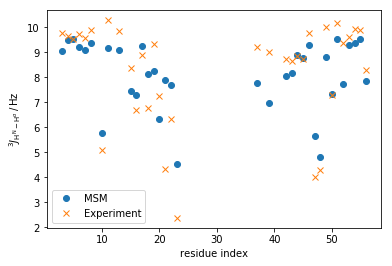

In [32]:
plt.plot(np.array(md_phi_rindex)[idx_md], M_gb3.stationary_distribution.dot(_E[:,idx_md]),'o',label='MSM')
plt.plot(expljc[idx_expl,0], expljc[idx_expl,1],'x', label='Experiment')
plt.xlabel('residue index')
plt.ylabel(r'$^3J_{\mathrm{H}^{\mathrm{N}}-\mathrm{H}^{\alpha}}\, / \, \mathrm{Hz}$')
plt.legend()

In general, we observe a fair qualitative agreement with the data. However, considering the upper error of 0.3Hz has been reported for these data a quantitative agreement is clearly missing. 

In [33]:
#Setup input for AMM estimation
ftrajs = np.split(JC_all[:, idx_md], np.cumsum([len(p) for p in phis_])[:-1], axis=0)
expl_data = expljc[idx_expl, 1].reshape(-1)
expl_sigmas = 0.3*np.ones(expl_data.shape)

# We increase the uncertainty for a subset of the data to illustrate non-uniform errors
expl_sigmas[18:21] = expl_sigmas[18:21] + 0.5

In [34]:
amm_gb3 = pe.msm.estimate_augmented_markov_model(dtrajs = dtrajs,
                                                 ftrajs = ftrajs,
                                                 lag = 200,
                                                 m = expl_data,
                                                 sigmas = expl_sigmas
                                                )

20-12-17 20:31:52 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[10] INFO     Experimental value 9.773668 is outside the support (8.563859,9.592259)
20-12-17 20:31:52 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[10] INFO     Experimental value 10.289247 is outside the support (8.263604,9.511690)
20-12-17 20:31:52 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[10] INFO     Experimental value 9.841005 is outside the support (7.972046,9.676753)
20-12-17 20:31:52 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[10] INFO     Experimental value 6.783495 is outside the support (7.426210,8.823338)
20-12-17 20:31:52 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[10] INFO     Experimental value 7.265520 is outside the support (5.143244,7.007398)
20-12-17 20:31:52 pyemma.msm.estimators.maximum_likelihood_msm.AugmentedMarkovModel[10] INFO     Experimental value 4.320463 is outside the support (6.732974,8

### And we have our first AMM on a molecular system!
Note how we get more output this time. We get notified that some our data-points are outside the support sampled during our MD simulation. We cannot hope to fit these data exactly, yet these data are still taken into account during estimation.

We can now see if we actually fit the experimental data better with the estimated AMM:

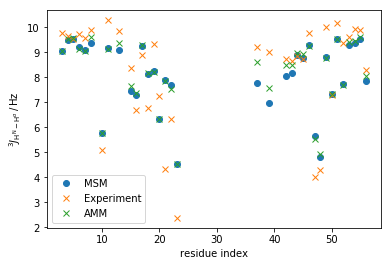

In [35]:
plt.plot(np.array(md_phi_rindex)[idx_md], M_gb3.stationary_distribution.dot(_E[:,idx_md]),'o',label='MSM')
plt.plot(expljc[idx_expl,0], expljc[idx_expl,1],'x', label='Experiment')
plt.plot(expljc[idx_expl,0], amm_gb3.mhat,'x', label='AMM')

plt.xlabel('residue index')
plt.ylabel(r'$^3J_{\mathrm{H}^{\mathrm{N}}-\mathrm{H}^{\alpha}}\, / \, \mathrm{Hz}$')
plt.legend()

This improved the fit alot! - Let us now coarse-grain the model into 2 meta-stable states using PCCA, to better understand what changes have happend during training:

In [36]:
M_gb3.pcca(2)
amm_gb3.pcca(2)

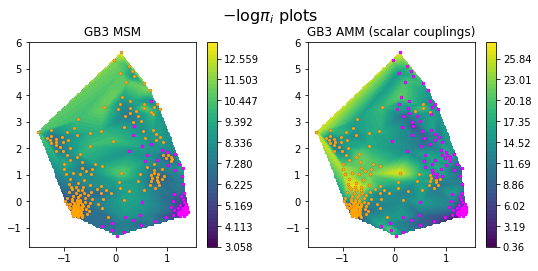

In [37]:
colors = ['orange', 'magenta']

fig,ax=plt.subplots(ncols=2,figsize=(8,4))

pe.plots.scatter_contour(cx, cy, -np.log(M_gb3.stationary_distribution), cmap='viridis',ax=ax[0])
pe.plots.scatter_contour(cx, cy, -np.log(amm_gb3.stationary_distribution), cmap='viridis',ax=ax[1])

for i, st in enumerate(M_gb3.metastable_sets):
    ax[0].scatter(cx[st], cy[st], c = colors[i], s = 5)
for i, st in enumerate(amm_gb3.metastable_sets):
    ax[1].scatter(cx[st], cy[st], c = colors[i], s = 5)

ax[0].set_title('GB3 MSM')
ax[1].set_title('GB3 AMM (scalar couplings)')
fig.tight_layout(pad=2.5)

fig.suptitle(r'$-\log{\pi_i}$ plots', fontsize=16)


We show minus log probabilities of the GB3 MSM and the GB3 AMM, and show the different meta-stable assignments using orange and magenta colors. Note how the meta-stable state assignments are slightly different in the two model in low-probability regions.

Some regions of conformational space are substantially downweighed in the AMM, in particular in the orange meta-stable configuration. Let's compare the coarse-grained stationary distributions to better quantify these differences:

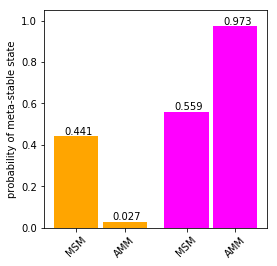

In [38]:
fig, ax=plt.subplots(figsize=(4,4))
xticks = []
for i, st in enumerate(M_gb3.metastable_sets):
    ax.bar(i/2.-0.11, M_gb3.stationary_distribution[st].sum(), color = colors[i], width = .2)
    ax.text(i/2.-0.11-0.055, M_gb3.stationary_distribution[st].sum()+0.01, "{:.3f}".format(M_gb3.stationary_distribution[st].sum()))
    xticks.append(i/2.-0.11)
    
for i, st in enumerate(amm_gb3.metastable_sets):
    ax.bar(i/2.+0.11, amm_gb3.stationary_distribution[st].sum(), color = colors[i], width = .2)
    ax.text(i/2.+0.11/2., amm_gb3.stationary_distribution[st].sum()+0.01, "{:.3f}".format(amm_gb3.stationary_distribution[st].sum()))
    xticks.append(i/2.+0.11)
ax.set_xticks(xticks)
ax.set_ylim((0.,1.05))
ax.set_xticklabels([ 'MSM','MSM', 'AMM', 'AMM'], rotation = 45)
ax.set_ylabel('probability of meta-stable state')


We see a strong repopulation towards the magenta state in the AMM compared to the MSM. 

Finally, let us inspect the slowest time-scale of the AMM vs the MSM:


In [39]:
print("Slowest MSM time-scale is {:.3f} microseconds.".format(M_gb3.timescales(k = 1)[0]*time_step_ps/1e6))
print("Slowest AMM time-scale is {:.3f} microseconds.".format(amm_gb3.timescales(k = 1)[0]*time_step_ps/1e6))

Slowest MSM time-scale is 1.407 microseconds.
Slowest AMM time-scale is 4.118 microseconds.


In this case we see a slow-down of the slowest time-scale. But note this value is very sensitive to numerical fluctuations in the estimation algorithm such as number of cluster-centers as we have very little simulation data in this example. Consequently, caution must be taken before making inferences about changes in time-scales with small data-sets like this. Generally we recommend repeating the estimation with multiple independent discretizations to test the robustness of these values. The meta-stable state distribution will also fluctuate as we change the number of clusters but this result is generally more robust. 

# Validations and sanity checks
To finish off, we will inspect our estimated AMM to ensure everything makes sense.

An interesting thing to inspect first is the Lagrange multipliers $\lambda_i$, which compensate for the systematic errors between the simulation and experimental ensembles.

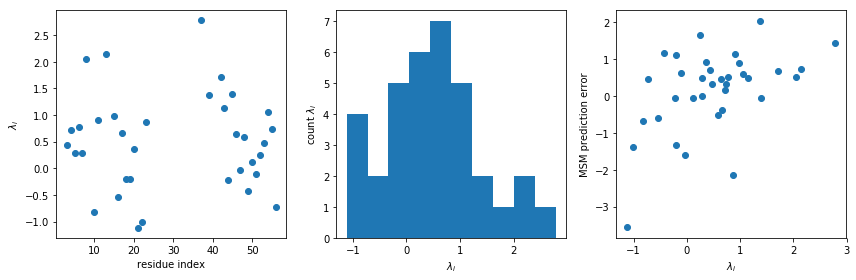

In [40]:
fig,ax=plt.subplots(ncols=3,figsize=(12,4))

ax[0].plot(expljc[idx_expl,0], amm_gb3.lagrange, 'o')
ax[0].set_xlabel('residue index')
ax[0].set_ylabel(r'$\lambda_i$')

ax[1].hist(amm_gb3.lagrange)
ax[1].set_xlabel(r'$\lambda_i$')
ax[1].set_ylabel(r'count $\lambda_i$')

ax[2].scatter(amm_gb3.lagrange, amm_gb3.m-M_gb3.stationary_distribution.dot(_E[:,idx_md]) )
ax[2].set_xlabel(r'$\lambda_i$')
ax[2].set_ylabel(r'MSM prediction error')

fig.tight_layout()

We see many of the Lagrange multipliers cluster around zero, which is good news for the forcefield as it illustratess that a substantial fraction of the observables are fairly well described by the unbiased simulation. However, a few larger values are also seen -- this can mean three different things: 
* the forcefield does not describe this observable well, 
* we have under-estimated the uncertainty of these observations 
* the experimental values are not assigned assigned to the right molecular feature.

The latter of thee points can be due either to mislabeling in either the computational analysis or on the experimental side.  

Note, the weak correlation between the MSM prediction error of our AMM lagrange multipliers is visible, which is naively expected.

Next, we look at the weighed variances of our experimental observable in the MSMs and AMMs

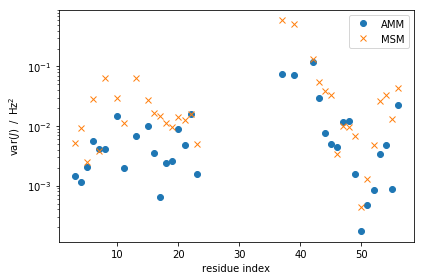

In [41]:
fig, ax=plt.subplots(ncols=1,figsize=(6,4))

msm_obs_var = M_gb3.stationary_distribution.dot((amm_gb3.E_active- M_gb3.stationary_distribution.dot(amm_gb3.E_active))**2. )
amm_obs_var = amm_gb3.stationary_distribution.dot((amm_gb3.E_active-amm_gb3.mhat)**2.)

ax.semilogy(expljc[idx_expl,0], amm_obs_var, 'o', label="AMM")
ax.semilogy(expljc[idx_expl,0], msm_obs_var, 'x', label="MSM")
ax.set_xlabel('residue index')
ax.set_ylabel(r'$\mathrm{var} (J)\; \; / \; \; \mathrm{Hz}^2$')
ax.legend()
fig.tight_layout()

We generally expect the variances to decrease in the observables as we are enforcing additional information about these quantities. This is also seen in this case.

### Cross-validation with other experimental data

Finally, we cross-validate the AMM using another set of scalar-couplings which are also sensitive to the backbone $\phi$ angle but is measured through the dihedral between the planes defined by the vectors ($H^N-N$, $N-C^{\alpha}$) the ($C^{\alpha}-C^{\beta}$,$C^{\alpha}-N$).

For this we can reuse alot of our featurization from above - but need a new set of Karplus parameters:

In [42]:
A2_ = 3.693 
B2_ = -0.514 
C2_ = 0.043 

In [43]:
# Load data
expljc2 = np.loadtxt('gb3_data/HN_CB_JC.dat')

#Compute scalar-couplings
Phi_all = np.vstack(phis_)+np.pi/3 # correct the phase 
cosPhi_all = np.cos(Phi_all)
cossqPhi_all = cosPhi_all*cosPhi_all
JC_all = A2_*cossqPhi_all+B2_*cosPhi_all+C2_

In [44]:
#Find intersection in set of computable and measured scalar couplings.
a=[int(i) for i in set(md_phi_rindex).intersection(expljc2[:,0])]
idx_expl = [np.where(expljc2[:,0]==i)[0][0] for i in a]
idx_md = [np.where(np.array(md_phi_rindex)==i)[0][0] for i in a]

In [45]:
# Compute E-matrix
dta = np.concatenate(dtrajs)
all_markov_states = set(dta)
_E = np.zeros((len(all_markov_states), JC_all.shape[1]))
for i, s in enumerate(all_markov_states):
    _E[i, :] = JC_all[np.where(dta == s)].mean(axis = 0)

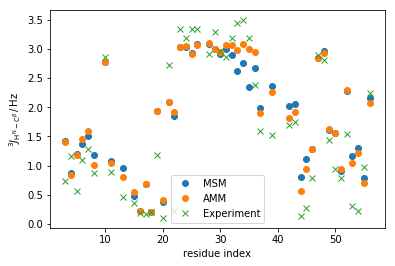

In [46]:
plt.plot(np.array(md_phi_rindex)[idx_md], M_gb3.stationary_distribution.dot(_E[:,idx_md]),'o',label='MSM')
plt.plot(np.array(md_phi_rindex)[idx_md], amm_gb3.stationary_distribution.dot(_E[:,idx_md]),'o',label='AMM')

plt.plot(expljc2[idx_expl,0], expljc2[idx_expl,1],'x', label='Experiment')
plt.xlabel('residue index')
plt.ylabel(r'$^3J_{\mathrm{H}^{\mathrm{N}}-\mathrm{C}^{\beta}}\, / \, \mathrm{Hz}$')
plt.legend()

In [47]:
print("RMS MSM: {:.3f}".format(np.std(M_gb3.stationary_distribution.dot(_E[:,idx_md])-expljc2[idx_expl,1])))
print("RMS AMM: {:.3f}".format(np.std(amm_gb3.stationary_distribution.dot(_E[:,idx_md])-expljc2[idx_expl,1])))


RMS MSM: 0.500
RMS AMM: 0.442


We observe an ever so slight improvement in the agreement with these complementary experimental data which suggests that our AMM is an overall more accurate model compared to the MSM. 

### Double-checking AMM estimation convergence
Sometimes it is instructutive to inspect model log-likelihood as a function of iteration, along with its absolute $\Delta$. Current default values for convergence is when $\Delta$ is less than $10^{-10}$.

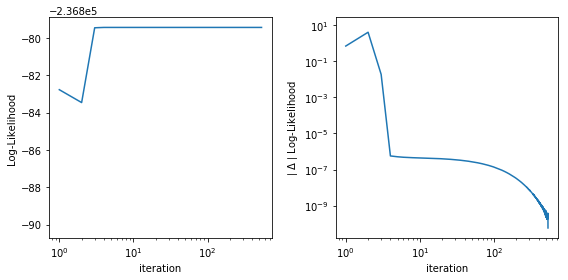

In [48]:
fig,ax=plt.subplots(ncols=2,figsize=(8,4))

ax[0].semilogx(amm_gb3._lls, '-')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel(r'Log-Likelihood')

ax[1].loglog(np.abs(np.diff(amm_gb3._lls[:])))
ax[1].set_xlabel(r'iteration')
ax[1].set_ylabel(r'$\mid\Delta\mid$Log-Likelihood')

fig.tight_layout()